# Imports

In [1]:
%%capture

!pip install category_encoders
!pip install statsmodels

In [3]:
import warnings; 
warnings.simplefilter('ignore')

In [4]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)

from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image

import category_encoders as ce
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess, Fourier
import scipy as sp
import scipy.fftpack
from fbprophet import Prophet
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler 

# Task 1 (40 points)

* EDA (10 points)
* Explain general setup of feature engineering (10 points)
* Use of scientific literature supporting the setup (5 points)
* Rationale for choice of final attributes (15 points)

In [483]:
df = pd.read_csv('data/mood.csv')
df['time'] = pd.to_datetime(df['time'])
df.head()

,Unnamed: 0,id,time,variable,value
0,1,AS14.01,2014-02-26 13:00:00,mood,6.0
1,2,AS14.01,2014-02-26 15:00:00,mood,6.0
2,3,AS14.01,2014-02-26 18:00:00,mood,6.0
3,4,AS14.01,2014-02-26 21:00:00,mood,7.0
4,5,AS14.01,2014-02-27 09:00:00,mood,6.0


## EDA and preprocessing

In [ ]:
profile = ProfileReport(df, title="Pandas Profiling Report")
profile.to_notebook_iframe()

We see that the column value contains potential outliers

### What are the dates of the experiment

In [ ]:
df.groupby('id')['time'].agg(['min', 'max']).sort_values(['min'])

Most of the participants started at the same time. The experiment lasted for a bit more than 2 months. A couple of participants started 1+ month later. Our guess is that the students are from NL and all live in the same timezone

### What are the values for different kinds of interaction with the device

In [ ]:
df.groupby(['variable'])['value'].agg(['min', 'max'])

1. call, sms appear only when there is a fact of this action, so there are no zeros.  
2. the duration of the call may be approximately calculated from the next event (rarely possible).  
3. activity is the value collected hourly. mean sth like the percentage ratio of the hour when the user was active.  
4. mood and circumplex are discrete
5. all the others mean the number of seconds spent on each of the activities

TODO:
1. All activities sum to the screen time
2. Add blink screen usages as a feature

### Outliers

In [ ]:
df['variable'].unique()

#### appCat.builtin

In [ ]:
df[df['variable'] == 'appCat.builtin'].boxplot(column=['value']);

In [ ]:
df[(df['variable'] == 'appCat.builtin')&(df['value'] < -80000)]

In [ ]:
df.shape

In [ ]:
df.drop(159972, axis=0, inplace=True)
df.shape

In [ ]:
df[df['variable'] == 'appCat.builtin'].boxplot(column=['value']);

In [ ]:
# df[df['value'] == df[df['variable'] == 'appCat.builtin'].agg({'value': ['min', 'max']})]

#### appCat.entertainment

In [ ]:
df[(df['variable'] == 'appCat.entertainment') & (df['value'] < 0)]

In [ ]:
df.drop(309805, axis=0, inplace=True)
df.shape

#### appCat.office

In [ ]:
df[(df['variable'] == 'appCat.office') & (df['value'] > 5000)]

In [ ]:
df[df['variable'] == 'appCat.office']['value'].hist();

In [ ]:
df[(df['id'] == 'AS14.29') & (df['variable'] == 'appCat.office')]['value'].hist();

33k seconds is about 9 hours. In general (and for this subject as well), we see that the time spent in the office apps is significantly smaller so we treat this case as a forgotten opened app

In [ ]:
df.drop(340707, axis=0, inplace=True)
df.shape

### Activity. Can it be a proxy for sleep? 

In [ ]:
df[(df['id'] == 'AS14.01') & (df['variable'] == 'mood')].sort_values(['time'])['time'].dt.hour.plot();

In [ ]:
sorted(df[(df['id'] == 'AS14.01') & (df['variable'] == 'mood')].sort_values(['time'])['time'].dt.hour.unique())

In [ ]:
plt.figure(figsize=(17, 12))
df[(df['id'] == 'AS14.02') & (df['variable'] == 'mood')].sort_values(['time']).plot('time', 'value');

In [ ]:
df[df['variable'] == 'activity']['value'].hist();

In [ ]:
df[(df['id'] == 'AS14.03') & (df['variable'] == 'activity')].sort_values(['time']).head(200).plot(x='time', y='value', figsize=(15,6));

TODO: 
1. add a binary (sth else) feature for sleep\not. sleep should be mutually exclusive with mood records
    1. continous period of 5+ hours
    2. correct it with surrounding events 
2. for each of the users use 75% percentile as sports

### Was the circumplex collected at the same time as the mood?

In [ ]:
Image(url= "images/circumplex_model.png", width=400, height=400)

In [ ]:
targets_num_df = df[df['variable'].isin(['mood', 'circumplex.valence', 'circumplex.arousal'])].\
    groupby(['id', 'time'])['variable'].unique()
targets_num_df.head()

In [ ]:
targets_num_df[targets_num_df.apply(lambda x: len(x)) != 3]

We don't see the cases when mood, circumplex.arousal, circumplex.valence were collected not at the same time. As they are all logically connected, we may conclude that not only the mood was collected as a target during the experiment, but the circumplex as well. Therefore, we have to treat this carefully as including of circumplex while predicting mood for the same time will have a clear leak

### Do we have the same variable indicated at the same time for the same user?

In [ ]:
df.duplicated(['id', 'time', 'variable']).value_counts()

In [ ]:
df[df.duplicated(['id', 'time', 'variable'], keep=False)]

In [ ]:
df[df['variable'] == 'mood']['value'].unique()

we see the duplicates. probably, they mean fractions (6.5, 0.5 etc)  
TODO Ned: find evidence

In [ ]:
df = df.groupby(['id', 'time', 'variable']).mean().reset_index()
df.shape

In [ ]:
df[(df['id'] == 'AS14.01') & (df['time'] == '2014-04-17 11:00:00')]

the unnamed (index) is weird

## Feature engineering non-dependent on train-test split

time may be encoded with a trigonometrical function to link 23 and 0

check the timing(hour) distribution across the days

don't forget to try find their local times (the first measurement is done in the morning)

## Pivoting data from the previous days as features

## Aggregating, Pivoting and feature engineering

In the data aggregation and preprocessing we first round the time to hours and create a pivot table, missing timestamps are filled in with rows of NaN. 3 features are extracted from the "activity" column:

asleep: has a value of 1 for rows with activity = 0 and 0 elsewhere\
active: has a value of 1 for rows with activity > 0.5 and 0 elsewhere\
missing_hour: has a value of 1 for rows with activity = NaN, 0 elsewhere

Next we round the time to days and calculate the mood change of a user during a day by subtracting the last mood entry from the first on a given day and saved in the column mood_change.

Then data is aggregated daily, group by "id" and "time", and apply different aggregation functions to the columns:\
take mean: "mood", "circumplex.arousal", "circumplex.valence"\
take sum: all other columns

Days with missing "mood" value are dropped and so are days with no data for more than 6 hours, signal
Mood from the previous day is saved in the column "mood_prev1", which is achieved by shifting the "mood" and "id" column by 1 row down and rows with NaN or rows where the "id" from the previous day is different than the "id" from the current one are droppped. This process is repeated to get the mood value for the next, the only diffrence is that now values are shifted up by 1 rows.

From the "time" column we extract the number of day on a week (0-6) and add a 4th order fourier series deterministic terms based on the "time" column, resulting in 3 sine and 3 cosine functions, similar to how Facebook Prophet works. This step is important since the weekly seasonality of the mood data is very high, meaning that the day of the week plays an important role in the mood. Sine and cosine functions are continous, which helps linear regression to fit the dataset better than the discrete day of the week number, which is expected to work better for decision trees.

Fitting deterministic terms fourier series based on calendar time is common practice, supported by many scientific papers:\
https://www.sciencedirect.com/science/article/pii/S2211467X20300778 \
https://www.tandfonline.com/doi/abs/10.1198/jasa.2011.tm09771

In [485]:
pivoted_df

,id,time,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,circumplex.arousal,circumplex.valence,mood,screen,sms
0,AS14.01,2014-02-17 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,AS14.01,2014-02-17 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,AS14.01,2014-02-18 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,AS14.01,2014-02-19 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,AS14.01,2014-02-19 17:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,AS14.33,2014-05-31 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1296,AS14.33,2014-05-31 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1297,AS14.33,2014-05-31 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1298,AS14.33,2014-05-31 11:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [484]:
# pivot and fill missing timestamps
df['time'] = df['time'].dt.floor('H')
pivoted_df = pd.pivot_table(df, values = 'value', index=['id','time'], columns = 'variable').reset_index()
for idx in pivoted_df['id'].unique():
    df_missing_data = pd.DataFrame()
    start, end = pivoted_df[pivoted_df['id'] == idx]['time'].agg(['min', 'max'])
    df_missing_data['time'] = pd.date_range(start, end, freq="60min").difference(pivoted_df[pivoted_df['id'] == idx]['time'])
    df_missing_data['id'] = idx

pivoted_df = pd.concat([pivoted_df,df_missing_data]).sort_values(['id', 'time'])
pivoted_df.sort_values(['id', 'time'], inplace=True)

In [486]:
# add binary column for sleep (no activity)
pivoted_df.loc[pivoted_df['activity'] == 0,'asleep'] = 1
pivoted_df['asleep'].fillna(0, inplace=True)

In [487]:
# add binary column for high activity
pivoted_df.loc[pivoted_df['activity'] > 0.5,'active'] = 1
pivoted_df['active'].fillna(0, inplace=True)

In [488]:
# add binary column for missing entry (activity value should be present for every hour)
pivoted_df.loc[pivoted_df['activity'].isna(),'missing_hour'] = 1
pivoted_df['missing_hour'].fillna(0, inplace=True)

In [489]:
# aggregate per mood entry
'''
pivoted_df['id_next'] = pivoted_df['id'].shift(-1)
cols = ['activity', 'appCat.builtin', 'appCat.communication',
       'appCat.entertainment', 'appCat.finance', 'appCat.game',
       'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel',
       'appCat.unknown', 'appCat.utilities', 'appCat.weather', 'call', 'screen', 'sms']

empty_row = pivoted_df.iloc[0][cols].fillna(0)*0
current_sum = pivoted_df.iloc[0][cols].fillna(0)*0
for i,row in pivoted_df.fillna(0).iterrows():
    if row['id'] == row['id_next']:
        current_sum += row[cols]
    else:
        current_sum = pivoted_df.iloc[0][cols].fillna(0)*0
        
    if row['mood'] != 0.:
        pivoted_df.loc[i,cols] = current_sum[cols]
        current_sum = pivoted_df.iloc[0][cols].fillna(0)*0
        
pivoted_df.drop(pivoted_df[pivoted_df['mood'].isna() == True].index, inplace=True)
pivoted_df.drop('id_next', axis=1,inplace=True)
''';

In [490]:
# calculate the mood change for the previous day
pivoted_df['time'] = pivoted_df['time'].dt.floor('D')
fist = pd.DataFrame(pivoted_df.loc[~pivoted_df['mood'].isna()].groupby(['id', 'time'])['mood'].first())
last = pd.DataFrame(pivoted_df.loc[~pivoted_df['mood'].isna()].groupby(['id', 'time'])['mood'].last())
mood_change = (fist - last)
mood_change.rename(columns={'mood': 'mood_change'}, inplace=True)

In [491]:
#aggregate daily (different agg func for different columns)
pivoted_df['time'] = pivoted_df['time'].dt.floor('D')
df2 = pivoted_df.groupby(['id', 'time']).mean()[['mood', 'circumplex.arousal', 'circumplex.valence']] #calculate mean for mood and circumplex
df3 = pivoted_df.loc[:, ~pivoted_df.columns.isin(['mood', 'circumplex.arousal', 'circumplex.valence'])].groupby(['id', 'time']).sum() #calculate sum for everything else
pivoted_df = pd.concat([df2,df3, mood_change], axis=1).reset_index()

In [492]:
# drop days without mood value
pivoted_df.drop(pivoted_df[pivoted_df['mood'].isna()].index, inplace=True)

In [493]:
# drop days with more than 6 hours missing
pivoted_df.drop(pivoted_df[pivoted_df['missing_hour'] > 6].index, inplace=True)

In [494]:
# add column for mood from previous day and drop rows with no data for previous day
pivoted_df['mood_prev1'] = pivoted_df['mood'].shift(1)
pivoted_df['id_prev1'] = pivoted_df['id'].shift(1)
pivoted_df = pivoted_df[pivoted_df['id_prev1'] == pivoted_df['id']]
pivoted_df.drop('id_prev1', axis=1, inplace=True)

In [495]:
# add column for mood for the next day to be used as target and drop rows with no data for following day
pivoted_df['mood_next'] = pivoted_df['mood'].shift(-1)
pivoted_df['id_next'] = pivoted_df['id'].shift(-1)
pivoted_df = pivoted_df[pivoted_df['id_next'] == pivoted_df['id']]
pivoted_df.drop('id_next', axis=1, inplace=True)

In [496]:
# add day of the week columns
pivoted_df['day_name'] = pivoted_df['time'].dt.day_name()
pivoted_df['day_num'] = pivoted_df['time'].dt.dayofweek

In [497]:
# Estimating weekly seasonality with partial fourier sum
#https://medium.com/analytics-vidhya/how-does-prophet-work-part-2-c47a6ceac511

fourier = CalendarFourier(freq='W', order=4)
dp = DeterministicProcess(index=pivoted_df['time'],
                          constant=False,
                          order=1,
                          seasonal=False,
                          additional_terms=[fourier],
                          drop=True)
f=dp.in_sample()
pivoted_df = pd.concat([pivoted_df.set_index('time'),f],axis=1).reset_index()
pivoted_df.drop('trend', axis=1, inplace=True)

In [498]:
# ordinal time encoding
#enc = ce.OrdinalEncoder(cols=['time'])
#pivoted_df = enc.fit_transform(pivoted_df)

In [499]:
# 2 NaN circumplex.valence
# replace with 0 ????
pivoted_df[pivoted_df['circumplex.valence'].isna()]
pivoted_df.fillna(0, inplace=True)

In [500]:
pivoted_df.head(50)

,time,id,mood,circumplex.arousal,circumplex.valence,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,screen,sms,asleep,active,missing_hour,mood_change,mood_prev1,mood_next,day_name,day_num,"sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)","cos(3,freq=W-SUN)"
0,2014-02-27,AS14.01,6.333333,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000,0.0,0.000000,0.0,0.0,0.0,3.0,-1.0,6.250000,6.200,Thursday,3,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521
1,2014-03-21,AS14.01,6.200000,0.200000,0.200000,3.083152,230.019006,763.079384,349.711300,12.334933,0.000,117.243500,193.873000,1214.028518,314.312750,0.00000,197.625786,0.000,4.0,3566.876103,0.0,7.0,2.0,0.0,0.0,6.333333,6.400,Friday,4,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521
2,2014-03-22,AS14.01,6.400000,0.600000,0.500000,3.790084,138.338687,882.779741,46.662000,7.025333,0.000,0.000000,98.143000,205.970250,37.305000,0.00000,117.621000,0.000,2.0,656.267264,1.0,1.0,2.0,0.0,2.0,6.200000,6.800,Saturday,5,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.623490
3,2014-03-23,AS14.01,6.800000,0.200000,0.800000,2.141117,145.124771,746.957427,49.187000,10.850750,0.000,0.000000,72.823000,369.885567,0.000000,0.00000,30.086000,30.386,0.0,974.988754,0.0,1.0,0.0,0.0,1.0,6.400000,6.000,Sunday,6,-0.781831,0.623490,-0.974928,-0.222521,-0.433884,-0.900969
4,2014-03-24,AS14.01,6.000000,0.800000,0.000000,1.895065,84.611298,698.855193,144.745286,11.368667,0.000,3.010000,66.558000,622.299232,83.961000,0.00000,178.732000,0.000,4.0,1313.119081,0.0,10.0,0.0,0.0,-1.0,6.800000,6.750,Monday,0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
5,2014-03-25,AS14.01,6.750000,0.500000,0.500000,2.360979,172.880177,931.204409,68.206000,10.763500,0.000,0.000000,125.156500,700.452361,0.000000,108.26125,44.578600,0.000,0.0,4218.026801,1.0,7.0,1.0,0.0,0.0,6.000000,6.600,Tuesday,1,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969
6,2014-03-26,AS14.01,6.600000,-0.200000,0.600000,2.431400,146.039865,893.799534,588.263667,17.443667,0.000,0.000000,97.498000,1504.717317,0.000000,0.00000,33.365000,0.000,0.0,2389.568615,0.0,8.0,1.0,0.0,0.0,6.750000,7.000,Wednesday,2,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490
7,2014-03-27,AS14.01,7.000000,0.200000,0.800000,3.509234,114.537705,1403.517290,268.855500,14.073000,0.000,28.429444,58.532000,693.608000,23.657000,0.00000,50.243500,0.000,1.0,1468.813362,1.0,9.0,3.0,0.0,0.0,6.600000,6.400,Thursday,3,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521
8,2014-03-28,AS14.01,6.400000,-0.600000,0.600000,2.296753,668.463475,351.740333,527.072167,25.276667,116.518,0.000000,225.951000,314.618821,278.752000,0.00000,84.892917,0.000,2.0,826.462362,0.0,10.0,1.0,0.0,-2.0,7.000000,8.000,Friday,4,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521
9,2014-03-29,AS14.01,8.000000,0.200000,1.000000,1.636867,302.869607,628.493960,961.423000,0.000000,0.000,0.000000,121.821000,88.853667,17.478333,0.00000,210.479217,0.000,1.0,2468.926018,1.0,8.0,0.0,0.0,1.0,6.400000,7.500,Saturday,5,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.623490


<AxesSubplot:>

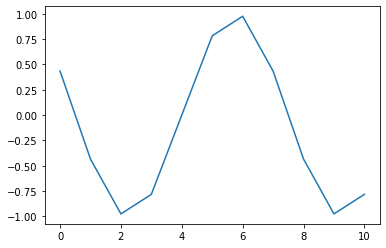

In [509]:
pivoted_df.loc[:10,'sin(1,freq=W-SUN)'].plot()

## Plots + Questions

In [ ]:
pd.concat([pivoted_df['mood'] - pivoted_df['mood_prev1'], pivoted_df['mood_change']], axis=1).rename(columns={0: 'mood_change'}).corr()

In [ ]:
# strong weekly seasonality of mood
pivoted_df.groupby('day_name').mean()['mood'].plot(ylabel='avg mood');

In [ ]:
# screen time of apps does not ad up to screen column
%matplotlib inline
apps =  ['appCat.builtin', 'appCat.communication',
       'appCat.entertainment', 'appCat.finance', 'appCat.game',
       'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel',
       'appCat.unknown', 'appCat.utilities', 'appCat.weather']
pivoted_df['screen_sum'] = pivoted_df[apps].sum(axis=1)
pivoted_df[['screen','screen_sum']]
(pivoted_df['screen'] - pivoted_df['screen_sum']).plot(figsize=(18,8 ), title='screen - sum(apps)');

### Value for activity missing in more than 14% of the rows!!!
there should be an entry for every hour\
Phone turned off when no data???
currently day deleted if no data for more than 6 hours

## Train-test split

In [23]:
from sklearn.model_selection import train_test_split#, StratifiedKFold

as we are going to predict in the feature, we will be able to train ML models only in the past

In [25]:
#pivoted_df['mood'].value_counts()

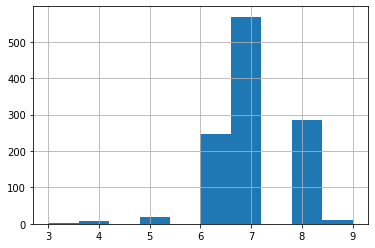

In [256]:
#pivoted_df['mood_next'] = round(pivoted_df['mood_next'])
#pivoted_df['mood_next'].hist();

In [334]:
pivoted_df.sort_values(['id','time'], inplace=True)

In [366]:
# Separetely split train and test for each user
pivoted_df.sort_values(['id','time'], inplace=True)

X_train, X_test, y_train, y_test = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
for idx in pivoted_df['id'].unique():
    X = pivoted_df[pivoted_df['id'] == idx].drop(['mood_next', 'day_name'], axis=1)
    y = pivoted_df[pivoted_df['id'] == idx]['mood_next']
    X_train_idx, X_test_idx, y_train_idx, y_test_idx = train_test_split(X, y, train_size=0.7, shuffle=False)
    X_train = pd.concat([X_train, X_train_idx])
    X_test = pd.concat([X_test, X_test_idx])
    y_train = pd.concat([y_train, y_train_idx])
    y_test = pd.concat([y_test, y_test_idx])
    
#X_test.reset_index(inplace=True, drop=True)
#y_test.reset_index(inplace=True, drop=True)

## Feature engineering

### Categoricals

ID may be encoded in advance as we do not expect new users during test period

In [367]:
enc = ce.OneHotEncoder(cols=['id'], 
                       use_cat_names=True)

X_train = enc.fit_transform(X_train)
print('X_train.shape', X_train.shape)
X_train.head(3)

X_train.shape (786, 59)


,time,id_AS14.01,id_AS14.02,id_AS14.03,id_AS14.05,id_AS14.06,id_AS14.07,id_AS14.08,id_AS14.09,id_AS14.12,id_AS14.13,id_AS14.14,id_AS14.15,id_AS14.16,id_AS14.17,id_AS14.19,id_AS14.20,id_AS14.23,id_AS14.24,id_AS14.25,id_AS14.26,id_AS14.27,id_AS14.28,id_AS14.29,id_AS14.30,id_AS14.31,id_AS14.32,id_AS14.33,mood,circumplex.arousal,circumplex.valence,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,screen,sms,asleep,active,missing_hour,mood_change,mood_prev1,day_num,"sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)","cos(3,freq=W-SUN)"
0,2014-02-27,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.333333,0.0,0.333333,0.000000,0.000000,0.000000,0.0000,0.000000,0.0,0.0000,0.000,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,3.0,-1.0,6.250000,3,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521
1,2014-03-21,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.200000,0.2,0.200000,3.083152,230.019006,763.079384,349.7113,12.334933,0.0,117.2435,193.873,1214.028518,314.31275,0.0,197.625786,0.0,4.0,3566.876103,0.0,7.0,2.0,0.0,0.0,6.333333,4,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521
2,2014-03-22,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.400000,0.6,0.500000,3.790084,138.338687,882.779741,46.6620,7.025333,0.0,0.0000,98.143,205.970250,37.30500,0.0,117.621000,0.0,2.0,656.267264,1.0,1.0,2.0,0.0,2.0,6.200000,5,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.623490


In [368]:
X_test = enc.transform(X_test)
X_test.tail(2)

,time,id_AS14.01,id_AS14.02,id_AS14.03,id_AS14.05,id_AS14.06,id_AS14.07,id_AS14.08,id_AS14.09,id_AS14.12,id_AS14.13,id_AS14.14,id_AS14.15,id_AS14.16,id_AS14.17,id_AS14.19,id_AS14.20,id_AS14.23,id_AS14.24,id_AS14.25,id_AS14.26,id_AS14.27,id_AS14.28,id_AS14.29,id_AS14.30,id_AS14.31,id_AS14.32,id_AS14.33,mood,circumplex.arousal,circumplex.valence,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,screen,sms,asleep,active,missing_hour,mood_change,mood_prev1,day_num,"sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)","cos(3,freq=W-SUN)"
1138,2014-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8.2,0.000000,1.2,2.479228,152.595619,340.446362,421.789167,0.0,0.0,76.996733,145.89915,1458.191042,0.000,0.0,5.111,0.0,4.0,4588.272501,1.0,12.0,0.0,0.0,3.0,6.2,2,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490
1139,2014-05-29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,7.0,-1.333333,1.0,4.064507,91.483901,363.487000,136.738000,0.0,0.0,0.000000,29.20200,548.205000,0.939,0.0,3.199,0.0,4.0,2494.684556,1.0,13.0,1.0,0.0,0.0,8.2,3,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521


### Normalising

# Task 2

## Evaluation

In [35]:
def eval_clf(y_test, test_pred):
    clf_report = classification_report(y_test,
                                       test_pred,)

    print(clf_report)

    conf_matrix = confusion_matrix(y_test,
                                   test_pred)
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=np.unique(y_test))
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.grid(False)
    disp.plot(ax=ax)

## Predict mood same as previous mood entry baseline (Benchmark Model (4 points))

In [ ]:
pivoted_df_per_mood['time'] = df['time'].dt.floor('D')
mood = pivoted_df_per_mood.groupby(['id', 'time']).mean().reset_index()['mood'].round(0)
mood_prev = pivoted_df_per_mood.groupby(['id', 'time']).mean().reset_index()['mood_prev1'].round(0)

In [ ]:
eval_clf(mood, mood_prev)

## Predict mood same as previous day baseline (Benchmark Model (4 points))

In [ ]:
eval_clf(pivoted_df['mood_next'].round(0), pivoted_df['mood'].round(0))

## Average baseline (Benchmark Model (4 points))

In [ ]:
avg_mood = np.mean(y_train)

In [ ]:
avg_mood

In [ ]:
test_pred = np.full(y_test.shape, round(avg_mood))

In [ ]:
eval_clf(y_test.round(0), test_pred)

## Feature Engineered model (8 points)

### DecisionTreeClassifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=4)
clf = clf.fit(X_train, y_train.round(0))

In [ ]:
train_pred = clf.predict(X_train)
eval_clf(y_train.round(0), train_pred.round(0))

In [ ]:
test_pred = clf.predict(X_test)
eval_clf(y_test.round(0), test_pred.round(0))

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot as plt

fig, axes = plt.subplots(nrows=1,
                        ncols=1,
                        figsize=(20, 7))

from sklearn import tree
tree.plot_tree(clf, 
               feature_names=X_test.columns, 
               class_names=[str(c) for c in clf.classes_],
            filled=True,
            max_depth=4,
            fontsize=9,
               );

In [ ]:
y_test[X_test[X_test['id_AS14.30'] == 1].index]

In [ ]:
pivoted_df[pivoted_df['id'] == 'AS14.01']['mood'].plot();

### RandomForestClassifier

In [469]:
from sklearn.ensemble import RandomForestClassifier

In [470]:
X_train.columns

Index(['time', 'id_AS14.01', 'id_AS14.02', 'id_AS14.03', 'id_AS14.05',
       'id_AS14.06', 'id_AS14.07', 'id_AS14.08', 'id_AS14.09', 'id_AS14.12',
       'id_AS14.13', 'id_AS14.14', 'id_AS14.15', 'id_AS14.16', 'id_AS14.17',
       'id_AS14.19', 'id_AS14.20', 'id_AS14.23', 'id_AS14.24', 'id_AS14.25',
       'id_AS14.26', 'id_AS14.27', 'id_AS14.28', 'id_AS14.29', 'id_AS14.30',
       'id_AS14.31', 'id_AS14.32', 'id_AS14.33', 'mood', 'circumplex.arousal',
       'circumplex.valence', 'activity', 'appCat.builtin',
       'appCat.communication', 'appCat.entertainment', 'appCat.finance',
       'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social',
       'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather',
       'call', 'screen', 'sms', 'asleep', 'active', 'missing_hour',
       'mood_change', 'mood_prev1', 'day_num', 'sin(1,freq=W-SUN)',
       'cos(1,freq=W-SUN)', 'sin(2,freq=W-SUN)', 'cos(2,freq=W-SUN)',
       'sin(3,freq=W-SUN)', 'cos(3,freq=W-SUN)'],
  

In [471]:
features = ['mood',
       'circumplex.arousal', 'circumplex.valence', 'activity',
       'appCat.builtin', 'appCat.communication', 'appCat.entertainment',
       'appCat.finance', 'appCat.game', 'appCat.office', 'appCat.other',
       'appCat.social', 'appCat.travel', 'appCat.unknown', 'appCat.utilities',
       'appCat.weather', 'call', 'screen', 'sms', 'asleep', 'active',
       'missing_hour', 'mood_change', 'mood_prev1', 'day_num',
       'sin(1,freq=W-SUN)', 'cos(1,freq=W-SUN)', 'sin(2,freq=W-SUN)',
       'cos(2,freq=W-SUN)', 'sin(3,freq=W-SUN)', 'cos(3,freq=W-SUN)']

              precision    recall  f1-score   support

         3.0       1.00      1.00      1.00         1
         4.0       1.00      1.00      1.00         7
         5.0       1.00      1.00      1.00        12
         6.0       1.00      1.00      1.00       174
         7.0       1.00      1.00      1.00       383
         8.0       1.00      1.00      1.00       202
         9.0       1.00      1.00      1.00         7

    accuracy                           1.00       786
   macro avg       1.00      1.00      1.00       786
weighted avg       1.00      1.00      1.00       786



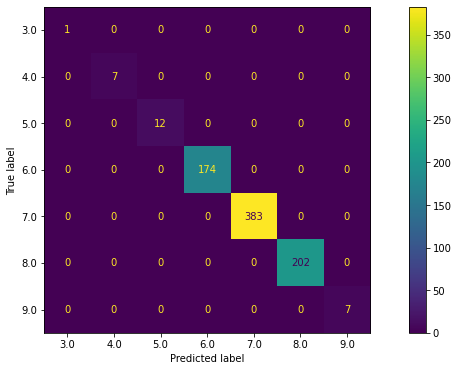

In [472]:
clf = RandomForestClassifier(max_depth=15)
clf = clf.fit(X_train[features], y_train.round(0))

train_pred = clf.predict(X_train[features])
eval_clf(y_train.round(0), train_pred.round(0))

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         1
         5.0       0.00      0.00      0.00         7
         6.0       0.49      0.27      0.35        73
         7.0       0.62      0.67      0.65       186
         8.0       0.42      0.58      0.49        83
         9.0       0.00      0.00      0.00         4

    accuracy                           0.55       354
   macro avg       0.26      0.25      0.25       354
weighted avg       0.53      0.55      0.53       354



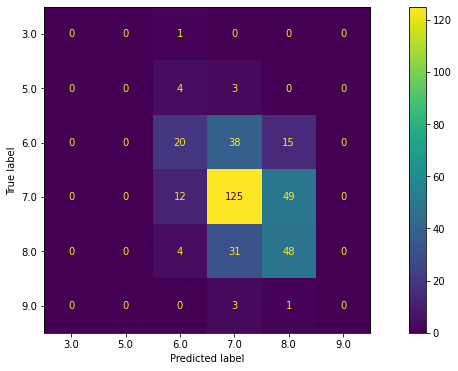

In [473]:
test_pred = clf.predict(X_test[features])
eval_clf(y_test.round(0), test_pred.round(0))

In [474]:
((y_test.round(0) - pd.DataFrame(test_pred))**2).mean()**0.5

0    1.173093
dtype: float64

In [262]:
for el in sorted(zip(X_train[features].columns, clf.feature_importances_), key=lambda x: x[1], 
                 reverse=True):
    print(el)

('mood_prev1', 0.06806228281201344)
('appCat.other', 0.06041551343251425)
('screen', 0.057858586275325585)
('appCat.communication', 0.053676668222447106)
('appCat.builtin', 0.051382965101442676)
('activity', 0.05031246002952205)
('appCat.social', 0.05004704458444564)
('mood', 0.04734905786322101)
('circumplex.arousal', 0.04597152844478521)
('appCat.entertainment', 0.044986357808523766)
('circumplex.valence', 0.04328502161524216)
('asleep', 0.03931916844624717)
('mood_change', 0.03457634872189907)
('appCat.travel', 0.03454516333103626)
('call', 0.028509228378912847)
('appCat.utilities', 0.026048893617244454)
('appCat.office', 0.02576684717090637)
('active', 0.022194904811893377)
('sin(3,freq=W-SUN)', 0.02118372497437412)
('missing_hour', 0.01924589033617381)
('sin(2,freq=W-SUN)', 0.019198192075484673)
('appCat.unknown', 0.01873255114532043)
('sin(1,freq=W-SUN)', 0.018686612333698005)
('day_num', 0.018403997039758067)
('appCat.finance', 0.01777781759908363)
('cos(1,freq=W-SUN)', 0.016129

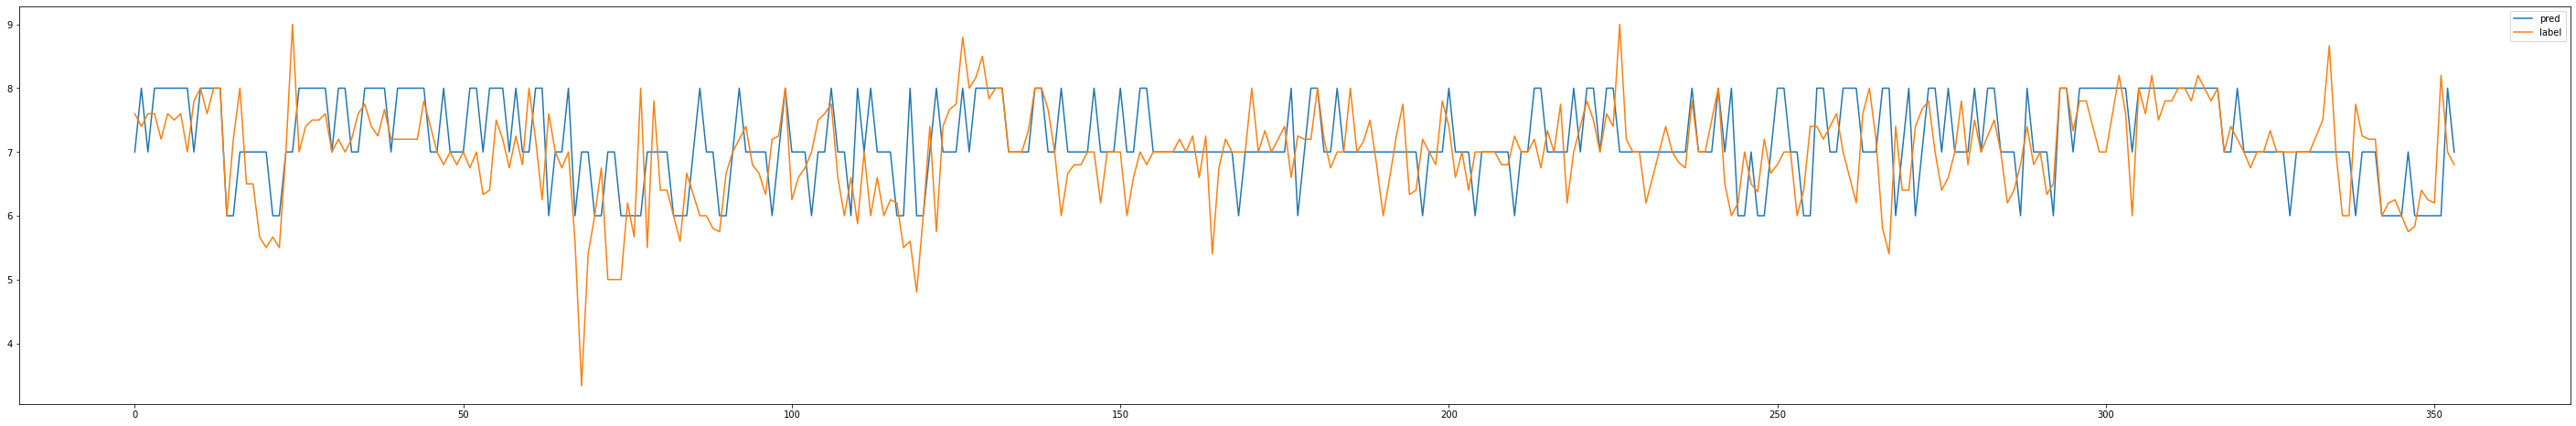

In [263]:
fig,ax = plt.subplots(figsize=(50,8))
ax.plot(test_pred, label='pred')
ax.plot(list(y_test[0]), label='label')
ax.legend()

## Linear Model

In [475]:
features = ['mood',
       'circumplex.arousal', 'circumplex.valence', 'activity',
       'appCat.builtin', 'appCat.communication', 'appCat.entertainment',
       'appCat.finance', 'appCat.game', 'appCat.office', 'appCat.other',
       'appCat.social', 'appCat.travel', 'appCat.unknown', 'appCat.utilities',
       'appCat.weather', 'call', 'screen', 'sms', 'asleep', 'active',
       'missing_hour', 'mood_change', 'mood_prev1', 'day_num',
       'sin(1,freq=W-SUN)', 'cos(1,freq=W-SUN)', 'sin(2,freq=W-SUN)',
       'cos(2,freq=W-SUN)', 'sin(3,freq=W-SUN)', 'cos(3,freq=W-SUN)']

In [476]:
features = ['id_AS14.01', 'id_AS14.02', 'id_AS14.03', 'id_AS14.05',
       'id_AS14.06', 'id_AS14.07', 'id_AS14.08', 'id_AS14.09', 'id_AS14.12',
       'id_AS14.13', 'id_AS14.14', 'id_AS14.15', 'id_AS14.16', 'id_AS14.17',
       'id_AS14.19', 'id_AS14.20', 'id_AS14.23', 'id_AS14.24', 'id_AS14.25',
       'id_AS14.26', 'id_AS14.27', 'id_AS14.28', 'id_AS14.29', 'id_AS14.30',
       'id_AS14.31', 'id_AS14.32', 'id_AS14.33', 'mood', 'circumplex.arousal',
       'circumplex.valence', 'activity', 'appCat.builtin',
       'appCat.communication', 'appCat.entertainment', 'appCat.finance',
       'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social',
       'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather',
       'call', 'screen', 'sms', 'asleep', 'active', 'missing_hour',
       'mood_change', 'mood_prev1', 'day_num', 'sin(1,freq=W-SUN)',
       'cos(1,freq=W-SUN)', 'sin(2,freq=W-SUN)', 'cos(2,freq=W-SUN)',
       'sin(3,freq=W-SUN)', 'cos(3,freq=W-SUN)']

In [477]:
# MinMax scale features
mm_scaler = MinMaxScaler()
X_train[features] = mm_scaler.fit_transform(X_train[features])
X_test[features] = mm_scaler.fit_transform(X_test[features])

new_features = []
for col in X_test[features].columns:
    X_train[col+'^2'] = X_train[col] ** 2
    X_test[col+'^2'] = X_test[col] ** 2
    new_features.append(col)
    new_features.append(col+'^2')
    
features = new_features

In [478]:
# Grid search hyperparams
from sklearn.model_selection import GridSearchCV 
from sklearn.linear_model import LogisticRegression 
model = linear_model.SGDRegressor()

param_grid = {
    'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05],
    'loss': ['squared_loss', 'huber', 'epsilon_insensitive'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'learning_rate': ['constant', 'optimal', 'invscaling'],
}

clf = GridSearchCV(model, param_grid)
clf.fit(X_train[features], y_train)
print("Best score: " + str(clf.best_score_))
print("Best params: " + str(clf.best_params_))
model = clf.best_estimator_

Best score: 0.15682098620522864
Best params: {'alpha': 0.01, 'learning_rate': 'constant', 'loss': 'epsilon_insensitive', 'penalty': 'l1'}


In [479]:
#model = linear_model.LinearRegression()

model.fit(X_train[features], y_train)

SGDRegressor(alpha=0.01, learning_rate='constant', loss='epsilon_insensitive',
             penalty='l1')

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         1
         4.0       0.00      0.00      0.00         7
         5.0       1.00      0.08      0.15        12
         6.0       0.57      0.14      0.23       174
         7.0       0.54      0.91      0.68       383
         8.0       0.71      0.34      0.46       202
         9.0       0.00      0.00      0.00         7

    accuracy                           0.56       786
   macro avg       0.40      0.21      0.22       786
weighted avg       0.59      0.56      0.50       786



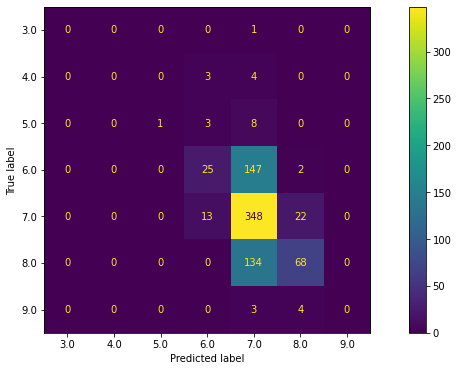

In [480]:
train_pred = pd.DataFrame(model.predict(X_train[features]))
eval_clf(y_train.round(0), train_pred.round(0))

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         1
         5.0       0.00      0.00      0.00         7
         6.0       0.42      0.11      0.17        73
         7.0       0.60      0.88      0.71       186
         8.0       0.65      0.48      0.55        83
         9.0       0.00      0.00      0.00         4

    accuracy                           0.60       354
   macro avg       0.28      0.25      0.24       354
weighted avg       0.55      0.60      0.54       354



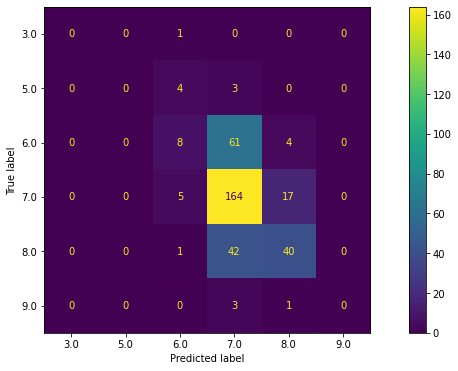

In [481]:
test_pred = pd.DataFrame(model.predict(X_test[features]))
eval_clf(y_test.round(0), test_pred.round(0))

In [482]:
((y_test.round(0) - test_pred.round(0))**2).mean()**0.5

0    1.096282
dtype: float64

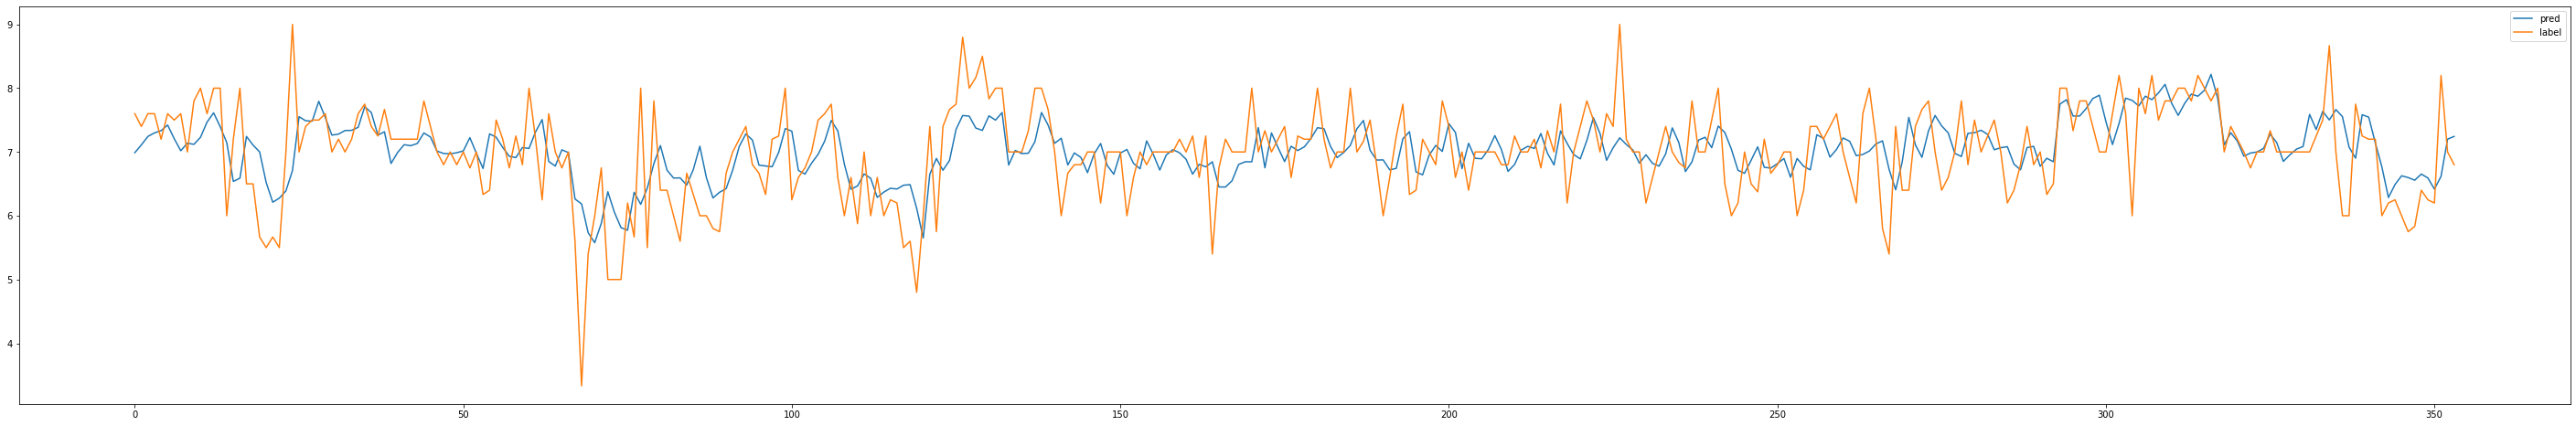

In [436]:
fig,ax = plt.subplots(figsize=(50,8))
ax.plot(list(test_pred[0]), label='pred')
ax.plot(list(y_test[0]), label='label')
ax.legend()

In [437]:
# align index of test_pred with index of y_test
test_pred = pd.concat([pd.DataFrame(y_test.index, columns=['index']), test_pred], axis=1).set_index('index')

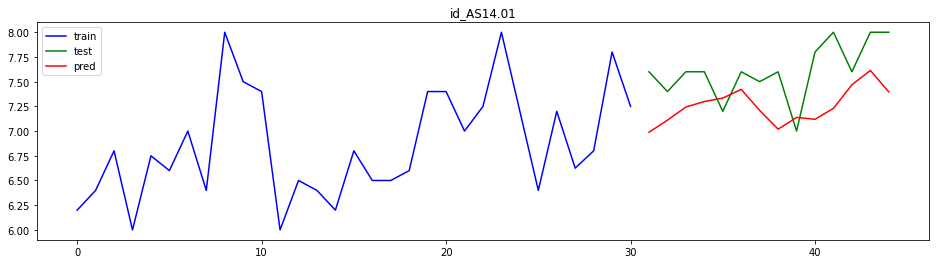

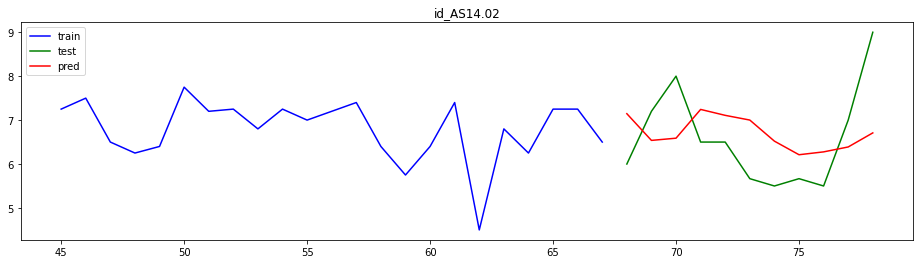

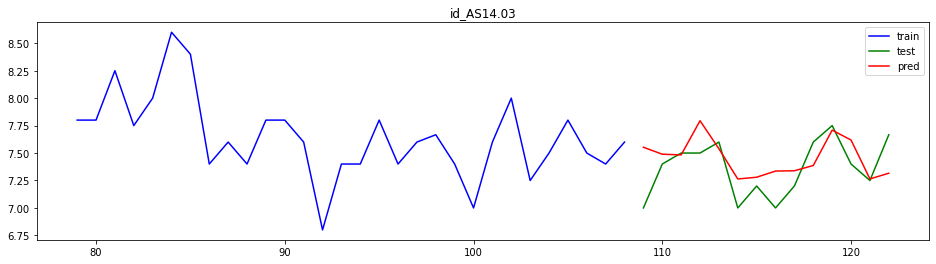

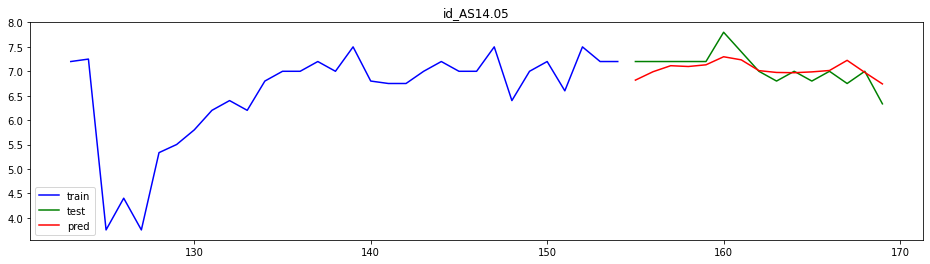

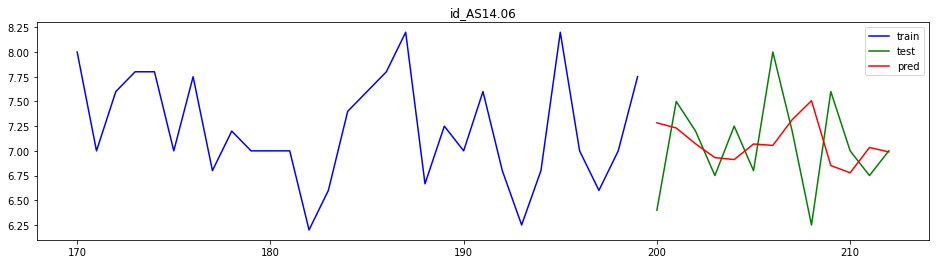

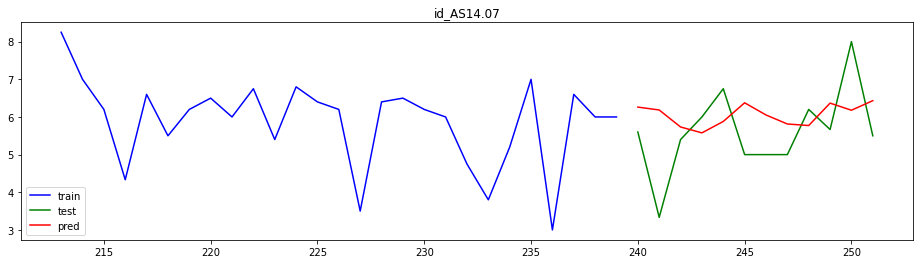

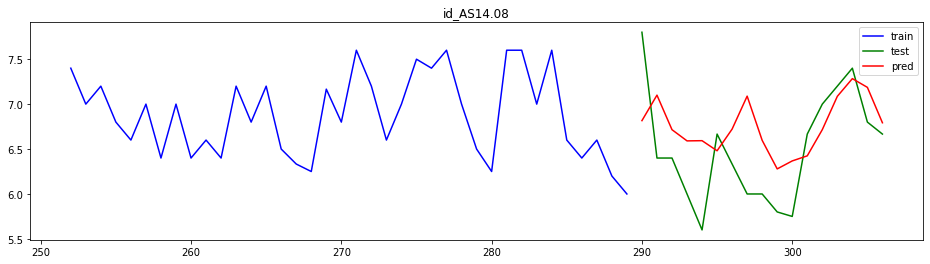

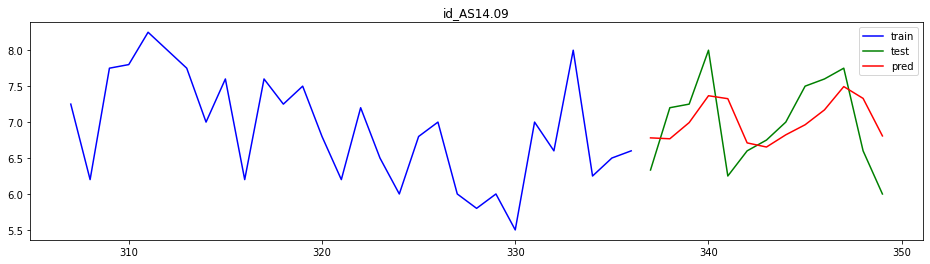

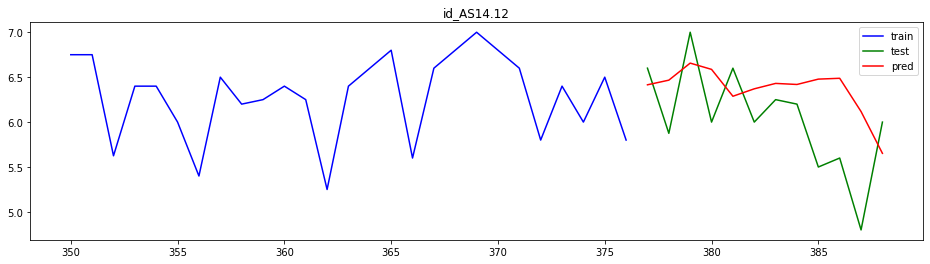

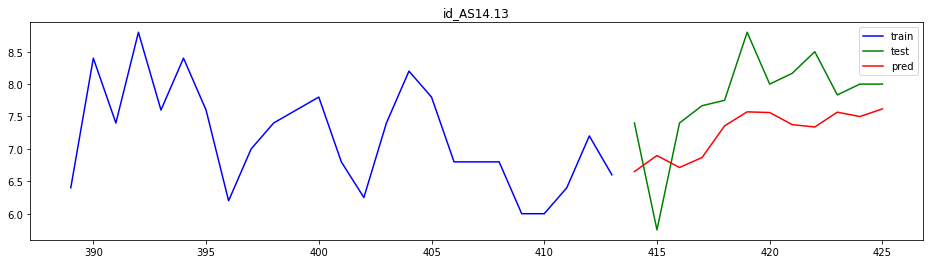

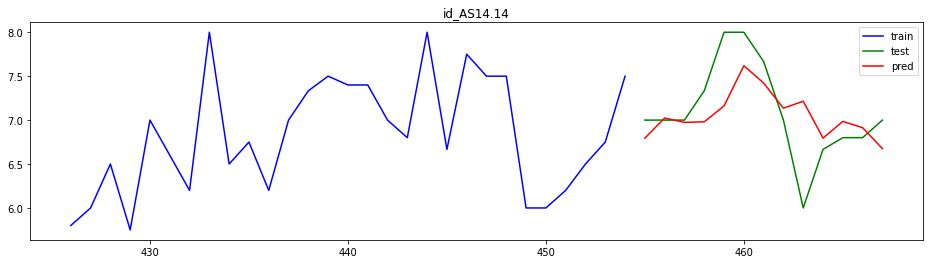

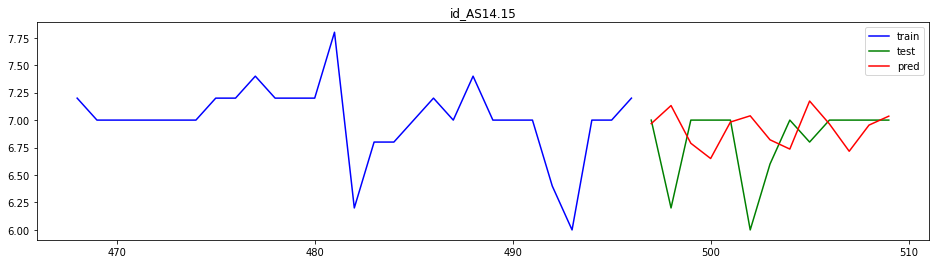

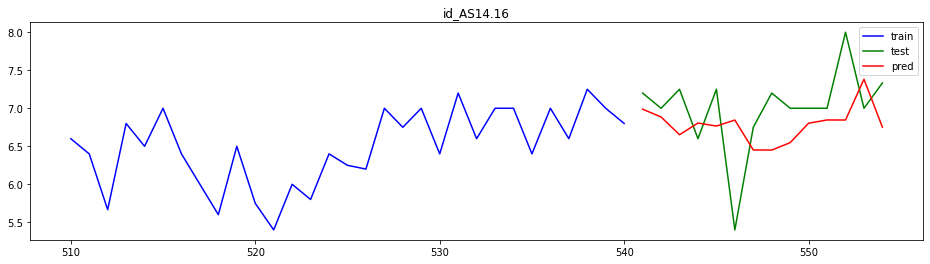

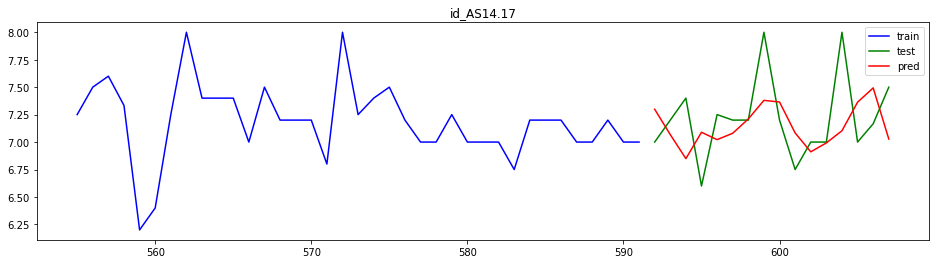

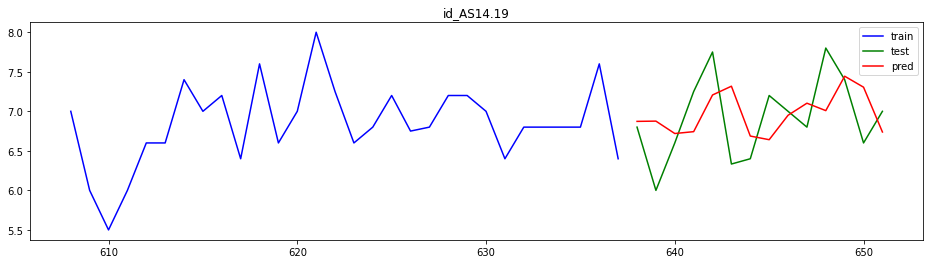

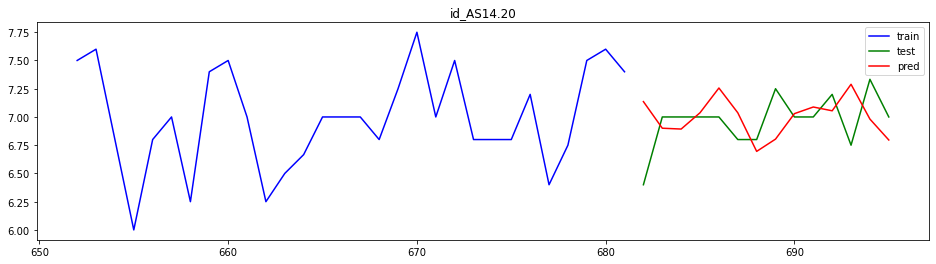

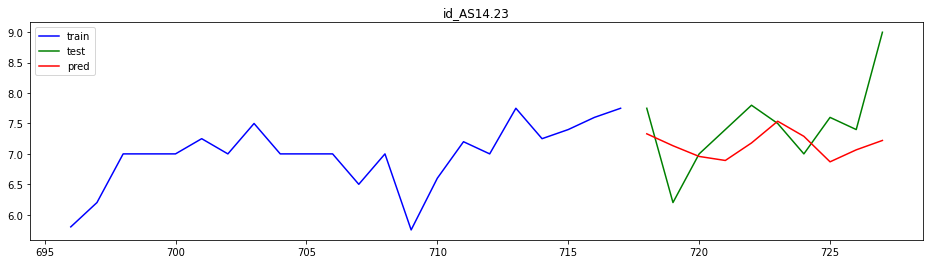

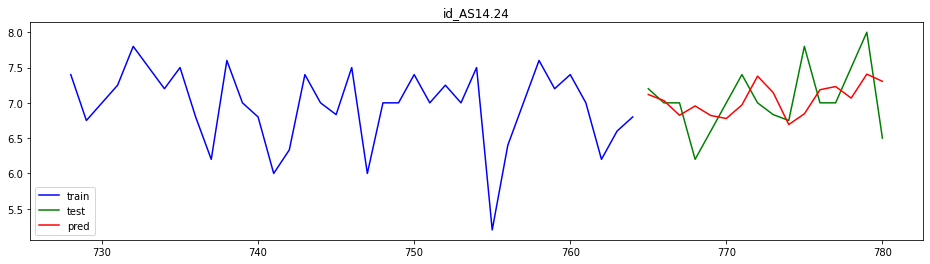

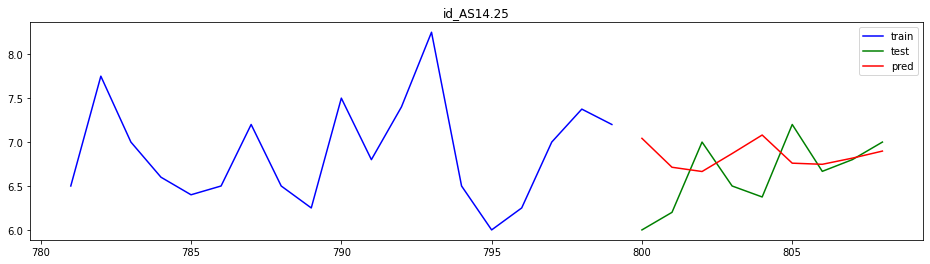

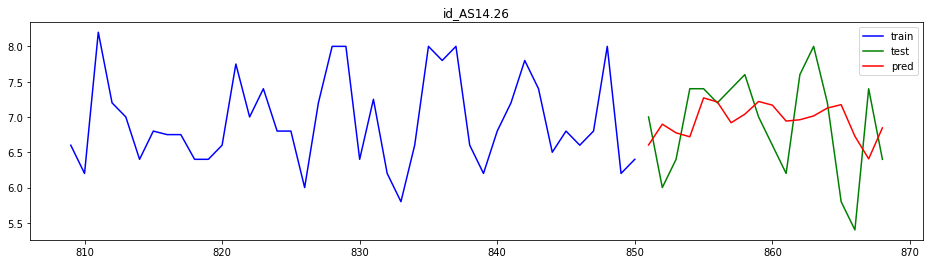

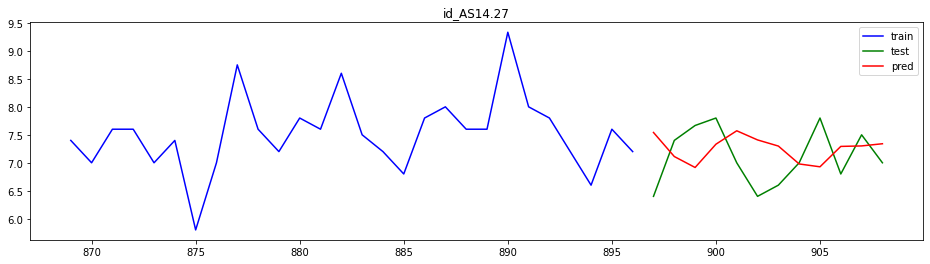

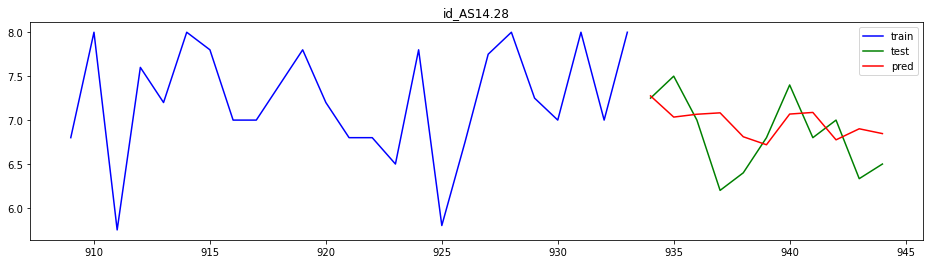

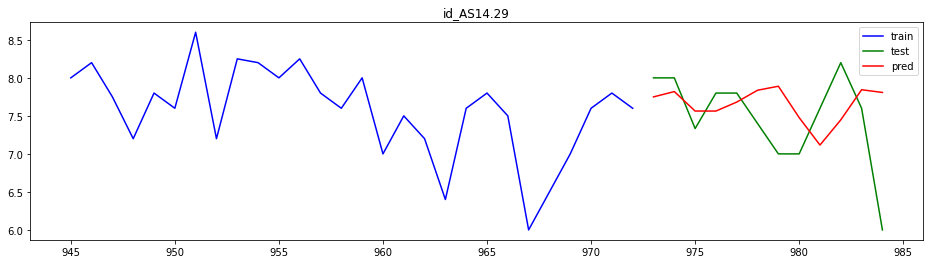

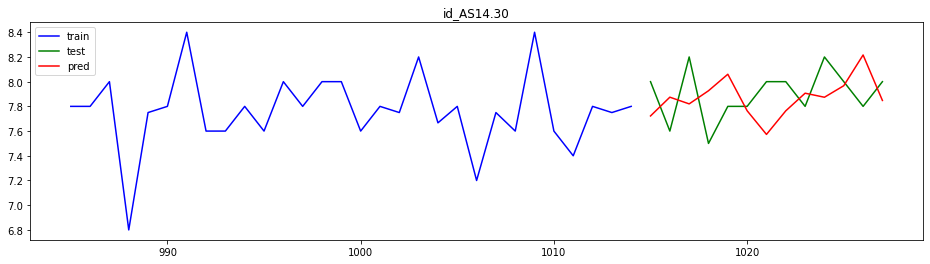

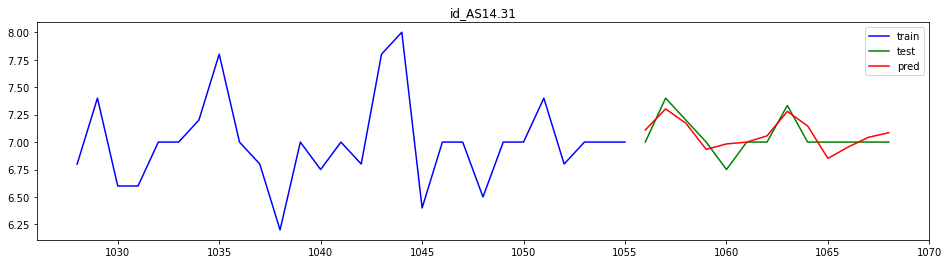

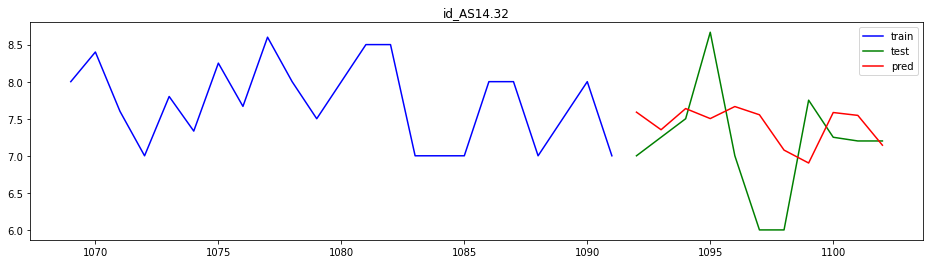

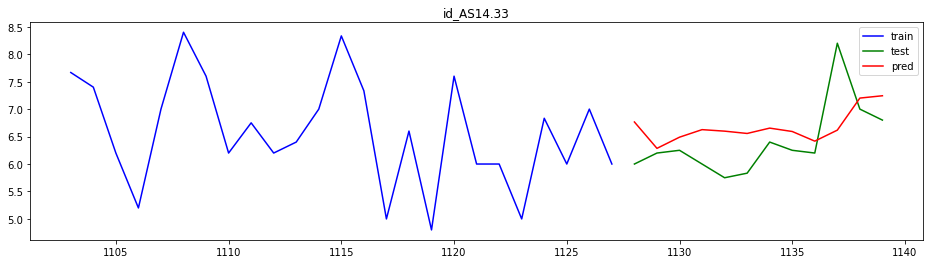

In [438]:
for idx in X_train.iloc[:,1:28].columns:
    fig,ax = plt.subplots(figsize=(16,4))
    ax.plot(y_train.loc[X_train[X_train[idx] == 1].index], label='train', c='b')
    ax.plot(y_test.loc[X_test[X_test[idx] == 1].index], label='test', c='g')
    ax.plot(test_pred.loc[X_test[X_test[idx] == 1].index], label='pred', c='r')
    plt.legend()
    plt.title(idx)

In [255]:
feature_importance = {}
feature_importance['feature'] = X_test[features].columns
feature_importance['importance'] = model.coef_.tolist()[0]
feature_importance['abs_importance'] = abs(model.coef_).tolist()[0]
feature_importance = pd.DataFrame(feature_importance)
feature_importance.sort_values('abs_importance', ascending=False)

,feature,importance,abs_importance
24,day_num,-2.726742e+13,2.726742e+13
25,"sin(1,freq=W-SUN)",-1.840059e+13,1.840059e+13
26,"cos(1,freq=W-SUN)",-8.639087e+12,8.639087e+12
30,"cos(3,freq=W-SUN)",-8.639087e+12,8.639087e+12
28,"cos(2,freq=W-SUN)",-8.639087e+12,8.639087e+12
27,"sin(2,freq=W-SUN)",-7.066617e+12,7.066617e+12
29,"sin(3,freq=W-SUN)",-2.022524e+12,2.022524e+12
0,mood,1.810085e+00,1.810085e+00
23,mood_prev1,1.496072e+00,1.496072e+00
5,appCat.communication,1.046494e+00,1.046494e+00


## Temporal Model 8

TODO NED: add plots

### AR model

### ARIMA

In [ ]:
y = train_test_dict['AS14.01']['train']

# Maps each participant to a fitted model
model_dict = {}
for participant in participants:
    train = train_test_dict[participant]['train']
    
    model = pm.auto_arima(train, start_p=1, start_q=1,
                          test='adf',       # use adftest to find optimal 'd'
                          max_p=5, max_q=5, # maximum p and q
                          m=1,              # frequency of series
                          d=None,           # let model determine 'd'
                          seasonal=False,   # No Seasonality (Might have to check for this shit?)
                          start_P=0, 
                          D=0, 
                          trace=False,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)
    model_dict[participant] = model

for participant in sorted(model_dict.keys()):
    model = model_dict[participant]
    print(f"{participant}\t\tAIC: {np.round(model.aic(), 2):.2f}\tBIC: {np.round(model.bic(), 2):.2f}\tParameters: {model.order}")

### Prophet

In [422]:
y_pred = pd.DataFrame()
for idx in pivoted_df['id'].unique():
    train = pd.concat([X_train, y_train], axis=1).loc[X_train['id_'+idx] == 1, ['time',0]].rename(columns={'time': 'ds', 0: 'y'})
    test = pd.concat([X_test, y_test], axis=1).loc[X_test['id_'+idx] == 1, ['time',0]].rename(columns={'time': 'ds', 0: 'y'})

    m = Prophet(interval_width=0.95, weekly_seasonality=True);
    model = m.fit(train);

    if len(test['ds']) > 0:
        forecast = m.predict(pd.DataFrame(test['ds']));
        y_pred = pd.concat([y_pred, forecast['yhat']])
    

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -2.21233
Iteration  1. Log joint probability =    46.2942. Improved by 48.5065.
Iteration  2. Log joint probability =    66.2296. Improved by 19.9354.
Iteration  3. Log joint probability =    75.7554. Improved by 9.52581.
Iteration  4. Log joint probability =    75.8872. Improved by 0.131766.
Iteration  5. Log joint probability =    76.0867. Improved by 0.199536.
Iteration  6. Log joint probability =    76.1281. Improved by 0.0413895.
Iteration  7. Log joint probability =      76.14. Improved by 0.0119558.
Iteration  8. Log joint probability =    76.1476. Improved by 0.00756558.
Iteration  9. Log joint probability =    76.1509. Improved by 0.00329717.
Iteration 10. Log joint probability =    76.1557. Improved by 0.0047771.
Iteration 11. Log joint probability =    76.1582. Improved by 0.00248861.
Iteration 12. Log joint probability =    76.1594. Improved by 0.0012108.
Iteration 13. Log joint probability =      76.16. Improved by 0.000650376.
Iteration 14

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 17.



Initial log joint probability = -8.70919
Iteration  1. Log joint probability =    30.2456. Improved by 38.9548.
Iteration  2. Log joint probability =    43.7676. Improved by 13.5219.
Iteration  3. Log joint probability =    47.7691. Improved by 4.0015.
Iteration  4. Log joint probability =    47.8739. Improved by 0.104788.
Iteration  5. Log joint probability =    48.0868. Improved by 0.212914.
Iteration  6. Log joint probability =    48.1005. Improved by 0.0137517.
Iteration  7. Log joint probability =    48.1084. Improved by 0.00785559.
Iteration  8. Log joint probability =    48.2114. Improved by 0.10306.
Iteration  9. Log joint probability =    48.2224. Improved by 0.0109515.
Iteration 10. Log joint probability =    48.2357. Improved by 0.0133032.
Iteration 11. Log joint probability =    48.2851. Improved by 0.0494045.
Iteration 12. Log joint probability =    48.4482. Improved by 0.16311.
Iteration 13. Log joint probability =    48.4689. Improved by 0.0206924.
Iteration 14. Log joi

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -1.2615
Iteration  1. Log joint probability =    53.6016. Improved by 54.8631.
Iteration  2. Log joint probability =    71.7954. Improved by 18.1937.
Iteration  3. Log joint probability =    86.1617. Improved by 14.3663.
Iteration  4. Log joint probability =    87.3446. Improved by 1.18292.
Iteration  5. Log joint probability =     87.608. Improved by 0.263373.
Iteration  6. Log joint probability =     87.634. Improved by 0.0259698.
Iteration  7. Log joint probability =      87.65. Improved by 0.016024.
Iteration  8. Log joint probability =    87.7624. Improved by 0.11242.
Iteration  9. Log joint probability =    87.8133. Improved by 0.0508758.
Iteration 10. Log joint probability =    88.4222. Improved by 0.608915.
Iteration 11. Log joint probability =    88.5294. Improved by 0.107155.
Iteration 12. Log joint probability =     88.575. Improved by 0.0456562.
Iteration 13. Log joint probability =    88.6084. Improved by 0.0333333.
Iteration 14. Log joint 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.



Initial log joint probability = -1.17319
Iteration  1. Log joint probability =    29.2873. Improved by 30.4605.
Iteration  2. Log joint probability =    49.1223. Improved by 19.835.
Iteration  3. Log joint probability =    50.8634. Improved by 1.74111.
Iteration  4. Log joint probability =     55.118. Improved by 4.25458.
Iteration  5. Log joint probability =    55.1606. Improved by 0.0426414.
Iteration  6. Log joint probability =    56.3967. Improved by 1.23602.
Iteration  7. Log joint probability =    56.5601. Improved by 0.16349.
Iteration  8. Log joint probability =    56.6725. Improved by 0.112403.
Iteration  9. Log joint probability =    56.7604. Improved by 0.087861.
Iteration 10. Log joint probability =    56.8277. Improved by 0.067329.
Iteration 11. Log joint probability =    56.8911. Improved by 0.0633234.
Iteration 12. Log joint probability =    57.0217. Improved by 0.130587.
Iteration 13. Log joint probability =    57.0912. Improved by 0.0695815.
Iteration 14. Log joint pr

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -1.39587
Iteration  1. Log joint probability =    29.1351. Improved by 30.531.
Iteration  2. Log joint probability =    47.7769. Improved by 18.6418.
Iteration  3. Log joint probability =    64.3396. Improved by 16.5628.
Iteration  4. Log joint probability =    69.4334. Improved by 5.09377.
Iteration  5. Log joint probability =    69.4584. Improved by 0.0250042.
Iteration  6. Log joint probability =    69.5354. Improved by 0.0769747.
Iteration  7. Log joint probability =    69.6202. Improved by 0.0848124.
Iteration  8. Log joint probability =    69.6306. Improved by 0.0103531.
Iteration  9. Log joint probability =    69.6628. Improved by 0.0321989.
Iteration 10. Log joint probability =    69.6763. Improved by 0.0135266.
Iteration 11. Log joint probability =    69.6846. Improved by 0.0083362.
Iteration 12. Log joint probability =    69.7037. Improved by 0.0191204.
Iteration 13. Log joint probability =     69.708. Improved by 0.00421663.
Iteration 14. Log

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.



Initial log joint probability = -5.94373
Iteration  1. Log joint probability =    21.3251. Improved by 27.2689.
Iteration  2. Log joint probability =    26.0627. Improved by 4.73756.
Iteration  3. Log joint probability =    42.3094. Improved by 16.2467.
Iteration  4. Log joint probability =     42.406. Improved by 0.0966324.
Iteration  5. Log joint probability =    42.8029. Improved by 0.39688.
Iteration  6. Log joint probability =     43.025. Improved by 0.222073.
Iteration  7. Log joint probability =    43.1833. Improved by 0.158352.
Iteration  8. Log joint probability =    43.2384. Improved by 0.0550515.
Iteration  9. Log joint probability =    43.2463. Improved by 0.00786927.
Iteration 10. Log joint probability =    43.2502. Improved by 0.0039199.
Iteration 11. Log joint probability =    43.2532. Improved by 0.00300227.
Iteration 12. Log joint probability =    43.2547. Improved by 0.0014996.
Iteration 13. Log joint probability =    43.2559. Improved by 0.00125902.
Iteration 14. Lo

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -4.12224
Iteration  1. Log joint probability =    44.1807. Improved by 48.303.
Iteration  2. Log joint probability =    68.0019. Improved by 23.8212.
Iteration  3. Log joint probability =    86.1613. Improved by 18.1593.
Iteration  4. Log joint probability =    88.1916. Improved by 2.03036.
Iteration  5. Log joint probability =    90.9114. Improved by 2.71981.
Iteration  6. Log joint probability =     91.301. Improved by 0.389606.
Iteration  7. Log joint probability =     91.306. Improved by 0.00499542.
Iteration  8. Log joint probability =    91.3143. Improved by 0.00823618.
Iteration  9. Log joint probability =    91.3999. Improved by 0.0856729.
Iteration 10. Log joint probability =    91.4589. Improved by 0.0589866.
Iteration 11. Log joint probability =    91.4919. Improved by 0.033032.
Iteration 12. Log joint probability =    91.5145. Improved by 0.0225238.
Iteration 13. Log joint probability =    91.5474. Improved by 0.0329005.
Iteration 14. Log jo

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -1.33191
Iteration  1. Log joint probability =    28.9798. Improved by 30.3117.
Iteration  2. Log joint probability =    61.2462. Improved by 32.2663.
Iteration  3. Log joint probability =    68.6795. Improved by 7.43335.
Iteration  4. Log joint probability =    68.7001. Improved by 0.0206214.
Iteration  5. Log joint probability =    68.7437. Improved by 0.0436036.
Iteration  6. Log joint probability =    68.7719. Improved by 0.0282121.
Iteration  7. Log joint probability =    68.8317. Improved by 0.0597997.
Iteration  8. Log joint probability =    68.8587. Improved by 0.0269278.
Iteration  9. Log joint probability =    68.8724. Improved by 0.0137167.
Iteration 10. Log joint probability =    68.9836. Improved by 0.111162.
Iteration 11. Log joint probability =    69.1476. Improved by 0.164006.
Iteration 12. Log joint probability =    69.1504. Improved by 0.00286986.
Iteration 13. Log joint probability =    69.1891. Improved by 0.0387045.
Iteration 14. Lo

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.



Initial log joint probability = -5.47383
Iteration  1. Log joint probability =    31.9737. Improved by 37.4476.
Iteration  2. Log joint probability =    53.3683. Improved by 21.3946.
Iteration  3. Log joint probability =    63.0735. Improved by 9.7052.
Iteration  4. Log joint probability =     63.429. Improved by 0.355531.
Iteration  5. Log joint probability =     63.459. Improved by 0.0299406.
Iteration  6. Log joint probability =    63.4976. Improved by 0.0386079.
Iteration  7. Log joint probability =    63.5284. Improved by 0.0308169.
Iteration  8. Log joint probability =     63.559. Improved by 0.0306203.
Iteration  9. Log joint probability =     63.576. Improved by 0.0169802.
Iteration 10. Log joint probability =    63.6929. Improved by 0.116917.
Iteration 11. Log joint probability =    63.9031. Improved by 0.210176.
Iteration 12. Log joint probability =    63.9193. Improved by 0.0161628.
Iteration 13. Log joint probability =    63.9254. Improved by 0.00615146.
Iteration 14. Log 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.



Initial log joint probability = -6.02738
Iteration  1. Log joint probability =    4.95092. Improved by 10.9783.
Iteration  2. Log joint probability =    22.5974. Improved by 17.6465.
Iteration  3. Log joint probability =    22.6136. Improved by 0.0162473.
Iteration  4. Log joint probability =     22.633. Improved by 0.0193525.
Iteration  5. Log joint probability =    22.7352. Improved by 0.102248.
Iteration  6. Log joint probability =     22.767. Improved by 0.0318057.
Iteration  7. Log joint probability =    48.8879. Improved by 26.1209.
Iteration  8. Log joint probability =    49.0575. Improved by 0.169562.
Iteration  9. Log joint probability =     49.315. Improved by 0.257533.
Iteration 10. Log joint probability =    49.7252. Improved by 0.410188.
Iteration 11. Log joint probability =    49.7345. Improved by 0.00929095.
Iteration 12. Log joint probability =    49.7918. Improved by 0.0572854.
Iteration 13. Log joint probability =    49.8353. Improved by 0.0435257.
Iteration 14. Log 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.



Initial log joint probability = -2.74113
Iteration  1. Log joint probability =    24.0501. Improved by 26.7912.
Iteration  2. Log joint probability =    38.7937. Improved by 14.7436.
Iteration  3. Log joint probability =    38.8237. Improved by 0.0300336.
Iteration  4. Log joint probability =    38.8455. Improved by 0.0217355.
Iteration  5. Log joint probability =    38.8649. Improved by 0.019399.
Iteration  6. Log joint probability =    38.8783. Improved by 0.0134848.
Iteration  7. Log joint probability =    38.9351. Improved by 0.0567778.
Iteration  8. Log joint probability =    53.4088. Improved by 14.4737.
Iteration  9. Log joint probability =    53.4185. Improved by 0.00969142.
Iteration 10. Log joint probability =    53.4303. Improved by 0.0118422.
Iteration 11. Log joint probability =    53.4667. Improved by 0.0363958.
Iteration 12. Log joint probability =     53.476. Improved by 0.00927367.
Iteration 13. Log joint probability =    53.5084. Improved by 0.0323761.
Iteration 14. 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.



Initial log joint probability = -2.6569
Iteration  1. Log joint probability =    46.0349. Improved by 48.6918.
Iteration  2. Log joint probability =    58.8448. Improved by 12.8099.
Iteration  3. Log joint probability =    60.8483. Improved by 2.00352.
Iteration  4. Log joint probability =    79.7768. Improved by 18.9285.
Iteration  5. Log joint probability =    80.9937. Improved by 1.21696.
Iteration  6. Log joint probability =    81.0336. Improved by 0.0398317.
Iteration  7. Log joint probability =     81.367. Improved by 0.333423.
Iteration  8. Log joint probability =    81.3999. Improved by 0.0329383.
Iteration  9. Log joint probability =    81.5122. Improved by 0.112292.
Iteration 10. Log joint probability =    81.5154. Improved by 0.00311958.
Iteration 11. Log joint probability =    81.6352. Improved by 0.11988.
Iteration 12. Log joint probability =    81.6397. Improved by 0.00448883.
Iteration 13. Log joint probability =    81.6717. Improved by 0.0319596.
Iteration 14. Log join

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -2.23307
Iteration  1. Log joint probability =    40.0378. Improved by 42.2709.
Iteration  2. Log joint probability =    66.6645. Improved by 26.6267.
Iteration  3. Log joint probability =    70.8778. Improved by 4.21326.
Iteration  4. Log joint probability =    70.9294. Improved by 0.0516075.
Iteration  5. Log joint probability =     71.004. Improved by 0.0746112.
Iteration  6. Log joint probability =    71.0775. Improved by 0.0734503.
Iteration  7. Log joint probability =    71.0958. Improved by 0.0183409.
Iteration  8. Log joint probability =    71.1741. Improved by 0.0782473.
Iteration  9. Log joint probability =    71.2131. Improved by 0.0390413.
Iteration 10. Log joint probability =     71.312. Improved by 0.0988871.
Iteration 11. Log joint probability =    71.5346. Improved by 0.222601.
Iteration 12. Log joint probability =    72.2471. Improved by 0.712498.
Iteration 13. Log joint probability =    72.4736. Improved by 0.226501.
Iteration 14. Log 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -3.09798
Iteration  1. Log joint probability =    70.1367. Improved by 73.2347.
Iteration  2. Log joint probability =     83.419. Improved by 13.2823.
Iteration  3. Log joint probability =    97.7999. Improved by 14.3809.
Iteration  4. Log joint probability =    101.654. Improved by 3.85456.
Iteration  5. Log joint probability =    101.814. Improved by 0.16001.
Iteration  6. Log joint probability =     101.84. Improved by 0.0255423.
Iteration  7. Log joint probability =    101.892. Improved by 0.0520518.
Iteration  8. Log joint probability =     101.96. Improved by 0.0683987.
Iteration  9. Log joint probability =    101.998. Improved by 0.0377838.
Iteration 10. Log joint probability =    102.125. Improved by 0.126465.
Iteration 11. Log joint probability =    102.147. Improved by 0.0226832.
Iteration 12. Log joint probability =    102.154. Improved by 0.00693112.
Iteration 13. Log joint probability =     102.19. Improved by 0.0361457.
Iteration 14. Log j

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -1.31866
Iteration  1. Log joint probability =    20.2458. Improved by 21.5644.
Iteration  2. Log joint probability =    40.7442. Improved by 20.4985.
Iteration  3. Log joint probability =    40.7619. Improved by 0.0176927.
Iteration  4. Log joint probability =    40.8054. Improved by 0.0435093.
Iteration  5. Log joint probability =    40.8195. Improved by 0.014082.
Iteration  6. Log joint probability =     40.855. Improved by 0.0354425.
Iteration  7. Log joint probability =    40.8771. Improved by 0.0221127.
Iteration  8. Log joint probability =    40.9044. Improved by 0.0273602.
Iteration  9. Log joint probability =    40.9342. Improved by 0.0297919.
Iteration 10. Log joint probability =    40.9539. Improved by 0.0196895.
Iteration 11. Log joint probability =    40.9914. Improved by 0.0374723.
Iteration 12. Log joint probability =    41.0034. Improved by 0.011958.
Iteration 13. Log joint probability =    41.0489. Improved by 0.0455351.
Iteration 14. L

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -1.34145
Iteration  1. Log joint probability =    3.02445. Improved by 4.3659.
Iteration  2. Log joint probability =    21.6986. Improved by 18.6742.
Iteration  3. Log joint probability =    71.5251. Improved by 49.8265.
Iteration  4. Log joint probability =    71.7021. Improved by 0.176964.
Iteration  5. Log joint probability =      71.77. Improved by 0.0679221.
Iteration  6. Log joint probability =    71.9098. Improved by 0.139748.
Iteration  7. Log joint probability =    72.0431. Improved by 0.133354.
Iteration  8. Log joint probability =    72.1837. Improved by 0.140515.
Iteration  9. Log joint probability =    72.2712. Improved by 0.0874994.
Iteration 10. Log joint probability =    72.3477. Improved by 0.0765208.
Iteration 11. Log joint probability =    72.4013. Improved by 0.0535991.
Iteration 12. Log joint probability =    72.4718. Improved by 0.0705178.
Iteration 13. Log joint probability =    73.4436. Improved by 0.971826.
Iteration 14. Log joi

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 16.



Initial log joint probability = -10.0704
Iteration  1. Log joint probability =    27.1655. Improved by 37.2359.
Iteration  2. Log joint probability =    41.8701. Improved by 14.7046.
Iteration  3. Log joint probability =     48.885. Improved by 7.01492.
Iteration  4. Log joint probability =    53.2645. Improved by 4.37952.
Iteration  5. Log joint probability =    54.7239. Improved by 1.45934.
Iteration  6. Log joint probability =     54.869. Improved by 0.145154.
Iteration  7. Log joint probability =     54.982. Improved by 0.113013.
Iteration  8. Log joint probability =    55.0081. Improved by 0.0260739.
Iteration  9. Log joint probability =    55.0391. Improved by 0.0310243.
Iteration 10. Log joint probability =    55.0639. Improved by 0.0247334.
Iteration 11. Log joint probability =    55.1391. Improved by 0.0752572.
Iteration 12. Log joint probability =    55.2304. Improved by 0.0912876.
Iteration 13. Log joint probability =    55.2604. Improved by 0.0299627.
Iteration 14. Log joi

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -3.15916
Iteration  1. Log joint probability =    22.9457. Improved by 26.1048.
Iteration  2. Log joint probability =    82.2216. Improved by 59.2759.
Iteration  3. Log joint probability =    83.4756. Improved by 1.25405.
Iteration  4. Log joint probability =    84.8718. Improved by 1.39619.
Iteration  5. Log joint probability =    85.0917. Improved by 0.219892.
Iteration  6. Log joint probability =    85.1207. Improved by 0.0290532.
Iteration  7. Log joint probability =    85.1522. Improved by 0.0314862.
Iteration  8. Log joint probability =    85.1753. Improved by 0.0230756.
Iteration  9. Log joint probability =    85.1891. Improved by 0.0138131.
Iteration 10. Log joint probability =    85.2153. Improved by 0.0261934.
Iteration 11. Log joint probability =    85.2216. Improved by 0.00632298.
Iteration 12. Log joint probability =    85.3006. Improved by 0.0789554.
Iteration 13. Log joint probability =    85.4235. Improved by 0.122941.
Iteration 14. Log 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 14.



Initial log joint probability = -11.8975
Iteration  1. Log joint probability =    23.9922. Improved by 35.8897.
Iteration  2. Log joint probability =    35.2851. Improved by 11.293.
Iteration  3. Log joint probability =    35.5665. Improved by 0.281392.
Iteration  4. Log joint probability =    38.0407. Improved by 2.47421.
Iteration  5. Log joint probability =      38.14. Improved by 0.099265.
Iteration  6. Log joint probability =    38.3161. Improved by 0.176066.
Iteration  7. Log joint probability =    38.3537. Improved by 0.0375906.
Iteration  8. Log joint probability =    43.2721. Improved by 4.91839.
Iteration  9. Log joint probability =    43.3709. Improved by 0.0988896.
Iteration 10. Log joint probability =    43.4202. Improved by 0.0492878.
Iteration 11. Log joint probability =    43.4352. Improved by 0.0149198.
Iteration 12. Log joint probability =    43.4522. Improved by 0.0170042.
Iteration 13. Log joint probability =     43.557. Improved by 0.104827.
Iteration 14. Log join

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -7.84596
Iteration  1. Log joint probability =    49.2886. Improved by 57.1345.
Iteration  2. Log joint probability =    74.6921. Improved by 25.4035.
Iteration  3. Log joint probability =    97.3032. Improved by 22.6111.
Iteration  4. Log joint probability =    98.7651. Improved by 1.46191.
Iteration  5. Log joint probability =    99.0984. Improved by 0.333349.
Iteration  6. Log joint probability =    99.1478. Improved by 0.0493964.
Iteration  7. Log joint probability =     99.164. Improved by 0.0161484.
Iteration  8. Log joint probability =    99.1971. Improved by 0.0331076.
Iteration  9. Log joint probability =    99.2142. Improved by 0.0170699.
Iteration 10. Log joint probability =    99.2253. Improved by 0.0111084.
Iteration 11. Log joint probability =    99.2265. Improved by 0.00124813.
Iteration 12. Log joint probability =    99.2369. Improved by 0.0104028.
Iteration 13. Log joint probability =    99.2404. Improved by 0.00351095.
Iteration 14. Lo

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.



Initial log joint probability = -4.08139
Iteration  1. Log joint probability =    41.3344. Improved by 45.4158.
Iteration  2. Log joint probability =    57.1335. Improved by 15.7991.
Iteration  3. Log joint probability =    61.6637. Improved by 4.5302.
Iteration  4. Log joint probability =    61.7956. Improved by 0.131875.
Iteration  5. Log joint probability =    61.8263. Improved by 0.0307898.
Iteration  6. Log joint probability =    61.8321. Improved by 0.00579015.
Iteration  7. Log joint probability =    61.8463. Improved by 0.0141867.
Iteration  8. Log joint probability =    61.8643. Improved by 0.0179879.
Iteration  9. Log joint probability =    61.9021. Improved by 0.0378292.
Iteration 10. Log joint probability =    61.9062. Improved by 0.00406694.
Iteration 11. Log joint probability =    61.9087. Improved by 0.00246324.
Iteration 12. Log joint probability =    61.9156. Improved by 0.00697541.
Iteration 13. Log joint probability =    61.9292. Improved by 0.0135143.
Iteration 14.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.



Initial log joint probability = -5.95058
Iteration  1. Log joint probability =    26.0281. Improved by 31.9787.
Iteration  2. Log joint probability =    47.7564. Improved by 21.7283.
Iteration  3. Log joint probability =    57.0875. Improved by 9.3312.
Iteration  4. Log joint probability =    58.1458. Improved by 1.05823.
Iteration  5. Log joint probability =    58.2541. Improved by 0.108335.
Iteration  6. Log joint probability =    58.4013. Improved by 0.147173.
Iteration  7. Log joint probability =    58.4243. Improved by 0.0230591.
Iteration  8. Log joint probability =    58.4691. Improved by 0.0447077.
Iteration  9. Log joint probability =     58.496. Improved by 0.0269575.
Iteration 10. Log joint probability =    58.5158. Improved by 0.0197806.
Iteration 11. Log joint probability =    58.5225. Improved by 0.00674531.
Iteration 12. Log joint probability =    58.5267. Improved by 0.00419164.
Iteration 13. Log joint probability =    58.5271. Improved by 0.000337044.
Iteration 14. Lo

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.



Initial log joint probability = -4.0705
Iteration  1. Log joint probability =    39.7708. Improved by 43.8413.
Iteration  2. Log joint probability =    55.5945. Improved by 15.8237.
Iteration  3. Log joint probability =     65.984. Improved by 10.3896.
Iteration  4. Log joint probability =    66.6073. Improved by 0.623313.
Iteration  5. Log joint probability =    66.6444. Improved by 0.0370641.
Iteration  6. Log joint probability =    66.6623. Improved by 0.0178889.
Iteration  7. Log joint probability =    66.6676. Improved by 0.00526982.
Iteration  8. Log joint probability =    66.6751. Improved by 0.00749876.
Iteration  9. Log joint probability =    66.7004. Improved by 0.0253427.
Iteration 10. Log joint probability =    66.7801. Improved by 0.0796593.
Iteration 11. Log joint probability =    66.8639. Improved by 0.0838177.
Iteration 12. Log joint probability =     66.895. Improved by 0.0310899.
Iteration 13. Log joint probability =    66.9538. Improved by 0.0588702.
Iteration 14. L

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -1.25767
Iteration  1. Log joint probability =    56.9758. Improved by 58.2334.
Iteration  2. Log joint probability =    75.0923. Improved by 18.1165.
Iteration  3. Log joint probability =    85.7743. Improved by 10.6821.
Iteration  4. Log joint probability =    86.7286. Improved by 0.954224.
Iteration  5. Log joint probability =     87.003. Improved by 0.274384.
Iteration  6. Log joint probability =    87.0243. Improved by 0.0213319.
Iteration  7. Log joint probability =     87.054. Improved by 0.0296874.
Iteration  8. Log joint probability =    87.0864. Improved by 0.0323959.
Iteration  9. Log joint probability =    87.0868. Improved by 0.000446494.
Iteration 10. Log joint probability =    87.0963. Improved by 0.00945298.
Iteration 11. Log joint probability =     87.107. Improved by 0.0107146.
Iteration 12. Log joint probability =    87.1106. Improved by 0.00362369.
Iteration 13. Log joint probability =    87.1144. Improved by 0.00382002.
Iteration 14

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.



Initial log joint probability = -4.03906
Iteration  1. Log joint probability =     44.923. Improved by 48.9621.
Iteration  2. Log joint probability =     45.567. Improved by 0.643926.
Iteration  3. Log joint probability =    73.3486. Improved by 27.7817.
Iteration  4. Log joint probability =    76.3901. Improved by 3.04145.
Iteration  5. Log joint probability =     76.465. Improved by 0.074869.
Iteration  6. Log joint probability =    76.4918. Improved by 0.0268067.
Iteration  7. Log joint probability =    76.4959. Improved by 0.00413666.
Iteration  8. Log joint probability =    76.5039. Improved by 0.00798873.
Iteration  9. Log joint probability =    76.5128. Improved by 0.00888826.
Iteration 10. Log joint probability =    76.5221. Improved by 0.00930731.
Iteration 11. Log joint probability =    76.5305. Improved by 0.00839981.
Iteration 12. Log joint probability =    76.5354. Improved by 0.00489122.
Iteration 13. Log joint probability =     76.537. Improved by 0.00157871.
Iteration 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 17.



Initial log joint probability = -8.67134
Iteration  1. Log joint probability =    32.6359. Improved by 41.3073.
Iteration  2. Log joint probability =     45.817. Improved by 13.1811.
Iteration  3. Log joint probability =    54.6704. Improved by 8.85335.
Iteration  4. Log joint probability =    55.8197. Improved by 1.1493.
Iteration  5. Log joint probability =     56.016. Improved by 0.196336.
Iteration  6. Log joint probability =    56.0998. Improved by 0.0837822.
Iteration  7. Log joint probability =     56.143. Improved by 0.043199.
Iteration  8. Log joint probability =    56.1573. Improved by 0.0143373.
Iteration  9. Log joint probability =    56.1964. Improved by 0.0391317.
Iteration 10. Log joint probability =    56.2054. Improved by 0.00891567.
Iteration 11. Log joint probability =    56.2068. Improved by 0.00143603.
Iteration 12. Log joint probability =    56.2162. Improved by 0.00944565.
Iteration 13. Log joint probability =    56.2192. Improved by 0.00294365.
Iteration 14. Lo

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.



Initial log joint probability = -6.01662
Iteration  1. Log joint probability =    22.1248. Improved by 28.1414.
Iteration  2. Log joint probability =    44.4042. Improved by 22.2794.
Iteration  3. Log joint probability =    48.3566. Improved by 3.95238.
Iteration  4. Log joint probability =    48.5073. Improved by 0.150711.
Iteration  5. Log joint probability =    48.5408. Improved by 0.0335037.
Iteration  6. Log joint probability =    48.5546. Improved by 0.01386.
Iteration  7. Log joint probability =    48.6074. Improved by 0.0527694.
Iteration  8. Log joint probability =    48.6154. Improved by 0.00802043.
Iteration  9. Log joint probability =    48.6166. Improved by 0.00121481.
Iteration 10. Log joint probability =     48.653. Improved by 0.0363458.
Iteration 11. Log joint probability =    48.6692. Improved by 0.0162532.
Iteration 12. Log joint probability =    48.6694. Improved by 0.000210622.
Iteration 13. Log joint probability =    48.6786. Improved by 0.00915022.
Iteration 14.

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         1
         4.0       0.00      0.00      0.00         0
         5.0       0.07      0.14      0.10         7
         6.0       0.32      0.25      0.28        73
         7.0       0.62      0.71      0.66       186
         8.0       0.46      0.36      0.41        83
         9.0       0.00      0.00      0.00         4

    accuracy                           0.51       354
   macro avg       0.21      0.21      0.21       354
weighted avg       0.50      0.51      0.50       354



ValueError: The number of FixedLocator locations (7), usually from a call to set_ticks, does not match the number of ticklabels (6).

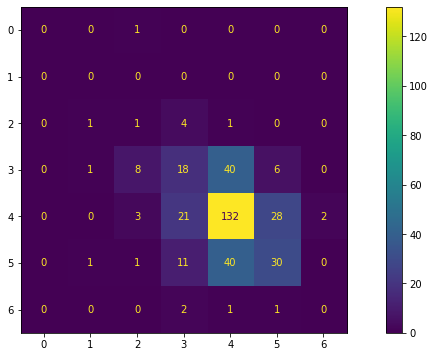

In [423]:
eval_clf(y_test.round(0), y_pred.round(0))

## Evaluation (validation / test) 10

## Illustrate performance with graphs 10